# Detecting Payment Card Fraud

In this section, we'll look at a credit card fraud detection dataset, and build a binary classification model that can identify transactions as either fraudulent or valid, based on provided, *historical* data. In a [2016 study](https://nilsonreport.com/upload/content_promo/The_Nilson_Report_10-17-2016.pdf), it was estimated that credit card fraud was responsible for over 20 billion dollars in loss, worldwide. Accurately detecting cases of fraud is an ongoing area of research.

<img src=notebook_ims/fraud_detection.png width=50% />

### Labeled Data

The payment fraud data set (Dal Pozzolo et al. 2015) was downloaded from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/data). This has features and labels for thousands of credit card transactions, each of which is labeled as fraudulent or valid. In this notebook, we'd like to train a model based on the features of these transactions so that we can predict risky or fraudulent transactions in the future.

### Binary Classification

Since we have true labels to aim for, we'll take a **supervised learning** approach and train a binary classifier to sort data into one of our two transaction classes: fraudulent or valid.  We'll train a model on training data and see how well it generalizes on some test data.

The notebook will be broken down into a few steps:
* Loading and exploring the data
* Splitting the data into train/test sets
* Defining and training a LinearLearner, binary classifier
* Making improvements on the model
* Evaluating and comparing model test performance

### Making Improvements

A lot of this notebook will focus on making improvements, as discussed in [this SageMaker blog post](https://aws.amazon.com/blogs/machine-learning/train-faster-more-flexible-models-with-amazon-sagemaker-linear-learner/). Specifically, we'll address techniques for:

1. **Tuning a model's hyperparameters** and aiming for a specific metric, such as high recall or precision.
2. **Managing class imbalance**, which is when we have many more training examples in one class than another (in this case, many more valid transactions than fraudulent).

---

First, import the usual resources.

In [120]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
import pickle

## Loading and Exploring the Data

Next, I am loading the data and unzipping the data in the file `creditcardfraud.zip`. This directory will hold one csv file of all the transaction data, `creditcard.csv`.

As in previous notebooks, it's important to look at the distribution of data since this will inform how we develop a fraud detection model. We'll want to know: How many data points we have to work with, the number and type of features, and finally, the distribution of data over the classes (valid or fraudulent).

In [2]:
# read in the csv file
local_data = 'creditcard.csv'

# print out some data
transaction_df = pd.read_csv(local_data)
print('Data shape (rows, cols): ', transaction_df.shape)
print()
transaction_df.head()

Data shape (rows, cols):  (284807, 31)



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
transaction_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Checking for class distribution

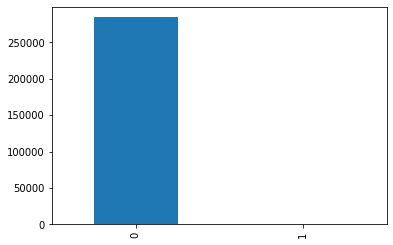

In [8]:
transaction_df['Class'].value_counts().plot(kind='bar');

### Calculating the percentage of fraudulent data

Take a look at the distribution of this transaction data over the classes, valid and fraudulent. 

The function `fraudulent_percentage`, below, Counts up the number of data points in each class and calculate the *percentage* of the data points that are fraudulent.

In [25]:
# Calculate the fraction of data points that are fraudulent
def fraudulent_percentage(transaction_df):
    '''Calculate the fraction of all data points that have a 'Class' label of 1; fraudulent.
       :param transaction_df: Dataframe of all transaction data points; has a column 'Class'
       :return: A fractional percentage of fraudulent data points/all points
    '''
    
    # your code here
    all_data_points = len(transaction_df.Class)
    fraudulent_data_points = len(transaction_df.Class[transaction_df.Class==1])
    
    fraudulent_percentage = round((fraudulent_data_points/all_data_points),4)*100
    
    return fraudulent_percentage
    
    


Test out your code by calling your function and printing the result.

In [26]:
# call the function to calculate the fraud percentage
fraud_percentage = fraudulent_percentage(transaction_df)

print('Fraudulent percentage = ', fraud_percentage)
print('Total # of fraudulent pts: ', fraud_percentage*transaction_df.shape[0])
print('Out of (total) pts: ', transaction_df.shape[0])


Fraudulent percentage =  0.16999999999999998
Total # of fraudulent pts:  48417.189999999995
Out of (total) pts:  284807


### Split into train/test datasets

In this example, we'll want to evaluate the performance of a fraud classifier; training it on some training data and testing it on *test data* that it did not see during the training process. So, we'll need to split the data into separate training and test sets.

Complete the `train_test_split` function, below. This function should:
* Shuffle the transaction data, randomly
* Split it into two sets according to the parameter `train_frac`
* Get train/test features and labels
* Return the tuples: (train_features, train_labels), (test_features, test_labels)

In [27]:
features = transaction_df.iloc[:, :-1]
labels = transaction_df['Class']

In [69]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, train_size=0.2, random_state=42)

In [70]:
Counter(y_test), Counter(y_train)

(Counter({1: 387, 0: 227459}), Counter({0: 56856, 1: 105}))

In [71]:
counter = Counter(y_train)
print('Before', counter)
# oversampling the train dataset using SMOTE
under_sample = RandomUnderSampler()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_ru, y_train_ru = under_sample.fit_resample(x_train, y_train)

counter = Counter(y_train_ru)
print('After',counter)

Before Counter({0: 56856, 1: 105})
After Counter({0: 105, 1: 105})


In [72]:
LR = LogisticRegression()
LR.fit(X_train_ru, y_train_ru)

LogisticRegression()

In [119]:
print(classification_report(y_test, RF.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    227459
           1       0.07      0.90      0.12       387

    accuracy                           0.98    227846
   macro avg       0.53      0.94      0.56    227846
weighted avg       1.00      0.98      0.99    227846



In [115]:
RF = RandomForestClassifier()
RF.fit(X_train_ru, y_train_ru)

RandomForestClassifier()

In [116]:
pred = RF.predict(x_test)
pred

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [117]:
y_test[3], pred[3]

(0, 0)

In [118]:
accuracy_score(y_test, RF.predict(x_test))

0.9781694653406248

<AxesSubplot:>

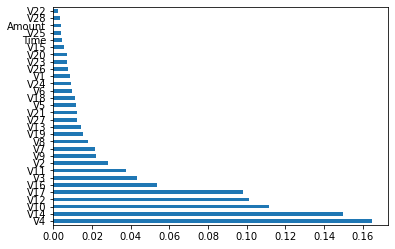

In [126]:
# get feature importance
feature_importance = pd.Series(RF.feature_importances_, index=x_train.columns)
feature_importance.nlargest(30).plot(kind='barh')

In [127]:
# Get names of top 20 features
indices = np.argsort(feature_importance)[::-1]
names = [x_train.columns[i] for i in indices]

In [177]:
# data = transaction_df[names[:10]]
# data.to_csv('Important_Features.csv', index=False)

In [147]:
# Use top 20 features to train new model
x_train_best = x_train[names[0:10]]
x_test_best = x_test[names[0:10]]

In [148]:
counter = Counter(y_train)
print('Before', counter)

under_sample = RandomUnderSampler()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_ru, y_train_ru = under_sample.fit_resample(x_train_best, y_train)

counter = Counter(y_train_ru)
print('After',counter)

Before Counter({0: 56856, 1: 105})
After Counter({0: 105, 1: 105})


In [149]:
RF = RandomForestClassifier()
RF.fit(X_train_ru, y_train_ru)
accuracy_score(y_test, RF.predict(x_test_best))

0.985182974465209

In [168]:
X_train_ru.iloc[209, :]

V4     3.533374
V14   -7.462961
V10   -6.540989
V12   -4.938159
V17   -4.472403
V16   -4.671032
V3    -7.616654
V11    4.404578
V2     2.943823
V9    -2.322716
Name: 209, dtype: float64

In [150]:
print(classification_report(y_test, RF.predict(x_test_best)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    227459
           1       0.09      0.87      0.17       387

    accuracy                           0.99    227846
   macro avg       0.55      0.93      0.58    227846
weighted avg       1.00      0.99      0.99    227846



In [152]:
pickle.dump(RF, open('RF_model.pkl', 'wb'))

---
# Modeling

Now that you've uploaded your training data, it's time to define and train a model!

In this notebook, you'll define and train the SageMaker, built-in algorithm, [LinearLearner](https://sagemaker.readthedocs.io/en/stable/linear_learner.html). 

A LinearLearner has two main applications:
1. For regression tasks in which a linear line is fit to some data points, and you want to produce a predicted output value given some data point (example: predicting house prices given square area).
2. For binary classification, in which a line is separating two classes of data and effectively outputs labels; either 1 for data that falls above the line or 0 for points that fall on or below the line.

<img src='notebook_ims/linear_separator.png' width=50% />

In this case, we'll be using it for case 2, and we'll train it to separate data into our two classes: valid or fraudulent. 

### Creating a LinearLearner Estimator

We've had some practice instantiating built-in models in SageMaker. All estimators require some constructor arguments to be passed in. Below we will be instantiating a LinearLearner estimator, using only the [LinearLearner documentation](https://sagemaker.readthedocs.io/en/stable/linear_learner.html) as a resource. This takes in a lot of arguments, but not all are required.

#### Instance Types

It is suggested that you use instances that are available in the free tier of usage: `'ml.c4.xlarge'` for training and `'ml.t2.medium'` for deployment.

In [20]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'creditcard'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=15)


### Converting data into a RecordSet format

Next, prepare the data for a built-in model by converting the train features and labels into numpy array's of float values. Then you can use the [record_set function](https://sagemaker.readthedocs.io/en/stable/linear_learner.html#sagemaker.LinearLearner.record_set) to format the data as a RecordSet and prepare it for training!

In [21]:
# create RecordSet of training data

train_x_np = train_features.astype('float32')
train_y_np = train_labels.astype('float32')

formatted_train_data = linear.record_set(train_x_np, labels=train_y_np)

### Training the Estimator

After instantiating your estimator, train it with a call to `.fit()`, passing in the formatted training data.

In [14]:
%%time 
# train the estimator on formatted training data
linear.fit(formatted_train_data)

2020-06-12 12:10:26 Starting - Starting the training job...
2020-06-12 12:10:29 Starting - Launching requested ML instances.........
2020-06-12 12:12:13 Starting - Preparing the instances for training.........
2020-06-12 12:13:53 Downloading - Downloading input data
2020-06-12 12:13:53 Training - Downloading the training image...
2020-06-12 12:14:12 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/12/2020 12:14:15 INFO 140632123914048] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5

[2020-06-12 12:14:35.447] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 6119, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.010330928617985404, "sum": 0.010330928617985404, "min": 0.010330928617985404}}, "EndTime": 1591964075.447876, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1591964075.447785}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.008765228896883864, "sum": 0.008765228896883864, "min": 0.008765228896883864}}, "EndTime": 1591964075.447966, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1591964075.44795}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.01032712537918

[2020-06-12 12:14:47.760] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 5985, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0069169620389315355, "sum": 0.0069169620389315355, "min": 0.0069169620389315355}}, "EndTime": 1591964087.760977, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1591964087.760879}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00574524320429893, "sum": 0.00574524320429893, "min": 0.00574524320429893}}, "EndTime": 1591964087.761072, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1591964087.761052}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006915968100

[2020-06-12 12:14:54.117] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 6346, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006276343655945668, "sum": 0.006276343655945668, "min": 0.006276343655945668}}, "EndTime": 1591964094.117785, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1591964094.117683}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005225318925464573, "sum": 0.005225318925464573, "min": 0.005225318925464573}}, "EndTime": 1591964094.117886, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1591964094.117863}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006276083052

[2020-06-12 12:15:06.624] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 17, "duration": 6375, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005591161470317361, "sum": 0.005591161470317361, "min": 0.005591161470317361}}, "EndTime": 1591964106.624531, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1591964106.624442}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004708522209570036, "sum": 0.004708522209570036, "min": 0.004708522209570036}}, "EndTime": 1591964106.62461, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1591964106.624592}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0055916021636

[2020-06-12 12:15:12.462] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 5827, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005391925841719661, "sum": 0.005391925841719661, "min": 0.005391925841719661}}, "EndTime": 1591964112.462202, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1591964112.462106}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0045703682456184275, "sum": 0.0045703682456184275, "min": 0.0045703682456184275}}, "EndTime": 1591964112.4623, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1591964112.462277}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00539248733

[2020-06-12 12:15:24.537] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 23, "duration": 6259, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005129939455482828, "sum": 0.005129939455482828, "min": 0.005129939455482828}}, "EndTime": 1591964124.537445, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1591964124.53736}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004400380541631325, "sum": 0.004400380541631325, "min": 0.004400380541631325}}, "EndTime": 1591964124.537545, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1591964124.537524}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00513069580

[2020-06-12 12:15:37.146] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 27, "duration": 6393, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004969843264201179, "sum": 0.004969843264201179, "min": 0.004969843264201179}}, "EndTime": 1591964137.146893, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1591964137.146802}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004306342939935138, "sum": 0.004306342939935138, "min": 0.004306342939935138}}, "EndTime": 1591964137.146963, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1591964137.14695}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00497065020


2020-06-12 12:15:54 Uploading - Uploading generated training model[2020-06-12 12:15:43.645] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 29, "duration": 6487, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004912319385825689, "sum": 0.004912319385825689, "min": 0.004912319385825689}}, "EndTime": 1591964143.645357, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1591964143.645262}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004274392560199278, "sum": 0.004274392560199278, "min": 0.004274392560199278}}, "EndTime": 1591964143.645441, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1591964143.645425}

#metrics {"Metrics": {"train_binary_classi


2020-06-12 12:16:01 Completed - Training job completed
Training seconds: 151
Billable seconds: 151
CPU times: user 904 ms, sys: 39.8 ms, total: 944 ms
Wall time: 6min 13s


## Deploying the trained model

Deploy your model to create a predictor. We'll use this to make predictions on our test data and evaluate the model.

In [16]:
%%time 
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, instance_type = 'ml.t2.medium')

-----------------!CPU times: user 297 ms, sys: 12.6 ms, total: 309 ms
Wall time: 8min 32s


---
# Evaluating Your Model

Once your model is deployed, you can see how it performs when applied to the test data.

According to the deployed [predictor documentation](https://sagemaker.readthedocs.io/en/stable/linear_learner.html#sagemaker.LinearLearnerPredictor), this predictor expects an `ndarray` of input features and returns a list of Records.
> "The prediction is stored in the "predicted_label" key of the `Record.label` field."

Let's first test our model on just one test point, to see the resulting list.

In [30]:
# test one prediction
test_x_np = test_features.astype('float32')
result = linear_predictor.predict(test_x_np[0])

print(result)

---

# Model Improvements

The default LinearLearner got a high accuracy, but still classified fraudulent and valid data points incorrectly. Specifically classifying more than 30 points as false negatives (incorrectly labeled, fraudulent transactions), and a little over 30 points as false positives (incorrectly labeled, valid transactions). Let's think about what, during training, could cause this behavior and what we could improve.

**1. Model optimization**
* If we imagine that we are designing this model for use in a bank application, we know that users do *not* want any valid transactions to be categorized as fraudulent. That is, we want to have as few **false positives** (0s classified as 1s) as possible. 
* On the other hand, if our bank manager asks for an application that will catch almost *all* cases of fraud, even if it means a higher number of false positives, then we'd want as few **false negatives** as possible.
* To train according to specific product demands and goals, we do not want to optimize for accuracy only. Instead, we want to optimize for a metric that can help us decrease the number of false positives or negatives. 

<img src='notebook_ims/precision_recall.png' width=40% />
     
In this notebook, we'll look at different cases for tuning a model and make an optimization decision, accordingly.

**2. Imbalanced training data**
* At the start of this notebook, we saw that only about 0.17% of the training data was labeled as fraudulent. So, even if a model labels **all** of our data as valid, it will still have a high accuracy. 
* This may result in some overfitting towards valid data, which accounts for some **false negatives**; cases in which fraudulent data (1) is incorrectly characterized as valid (0).

So, let's address these issues in order; first, tuning our model and optimizing for a specific metric during training, and second, accounting for class imbalance in the training set. 


## Improvement: Model Tuning

Optimizing according to a specific metric is called **model tuning**, and SageMaker provides a number of ways to automatically tune a model.


### Create a LinearLearner and tune for higher precision 

**Scenario:**
* A bank has asked you to build a model that detects cases of fraud with an accuracy of about 85%. 

In this case, we want to build a model that has as many true positives and as few false negatives, as possible. This corresponds to a model with a high **recall**: true positives / (true positives + false negatives). 

To aim for a specific metric, LinearLearner offers the hyperparameter `binary_classifier_model_selection_criteria`, which is the model evaluation criteria for the training dataset. A reference to this parameter is in [LinearLearner's documentation](https://sagemaker.readthedocs.io/en/stable/linear_learner.html#sagemaker.LinearLearner). We'll also have to further specify the exact value we want to aim for; read more about the details of the parameters, [here](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html).

I will assume that performance on a training set will be within about 5% of the performance on a test set. So, for a recall of about 85%, I'll aim for a bit higher, 90%.

In [12]:
# instantiate a LinearLearner
# tune the model for a higher recall
linear_recall = LinearLearner(role=role,
                              train_instance_count=1, 
                              train_instance_type='ml.c4.xlarge',
                              predictor_type='binary_classifier',
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              epochs=15,
                              binary_classifier_model_selection_criteria='precision_at_target_recall', # target recall
                              target_recall=0.9) # 90% recall


### Train the tuned estimator

Fit the new, tuned estimator on the formatted training data.

In [39]:
%%time 
# train the estimator on formatted training data
linear_recall.fit(formatted_train_data)

2020-06-12 13:27:55 Starting - Starting the training job...
2020-06-12 13:27:57 Starting - Launching requested ML instances.........
2020-06-12 13:29:40 Starting - Preparing the instances for training.........
2020-06-12 13:31:17 Downloading - Downloading input data
2020-06-12 13:31:17 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/12/2020 13:31:39 INFO 139764397803328] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u

[2020-06-12 13:31:52.504] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 6650, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.01697396398668912, "sum": 0.01697396398668912, "min": 0.01697396398668912}}, "EndTime": 1591968712.50451, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1591968712.504409}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.014988560247660881, "sum": 0.014988560247660881, "min": 0.014988560247660881}}, "EndTime": 1591968712.504603, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1591968712.504585}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.01696843108459932

[2020-06-12 13:32:04.704] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 5991, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.008034130657138537, "sum": 0.008034130657138537, "min": 0.008034130657138537}}, "EndTime": 1591968724.704603, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1591968724.704501}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006699231958868516, "sum": 0.006699231958868516, "min": 0.006699231958868516}}, "EndTime": 1591968724.704713, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1591968724.704691}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0080317853203

[2020-06-12 13:32:17.018] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 5999, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006276343655945668, "sum": 0.006276343655945668, "min": 0.006276343655945668}}, "EndTime": 1591968737.01862, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1591968737.01852}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005225318925464573, "sum": 0.005225318925464573, "min": 0.005225318925464573}}, "EndTime": 1591968737.018733, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1591968737.01871}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006276083052457

[2020-06-12 13:32:22.881] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 5852, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005869037068668922, "sum": 0.005869037068668922, "min": 0.005869037068668922}}, "EndTime": 1591968742.881774, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1591968742.881681}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004911643637484642, "sum": 0.004911643637484642, "min": 0.004911643637484642}}, "EndTime": 1591968742.881882, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1591968742.881861}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005869176341

[2020-06-12 13:32:35.817] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 6582, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005391925841719661, "sum": 0.005391925841719661, "min": 0.005391925841719661}}, "EndTime": 1591968755.817238, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1591968755.81714}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0045703682456184275, "sum": 0.0045703682456184275, "min": 0.0045703682456184275}}, "EndTime": 1591968755.817328, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1591968755.81731}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00539248733

[2020-06-12 13:32:41.885] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 21, "duration": 6056, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005243560808387833, "sum": 0.005243560808387833, "min": 0.005243560808387833}}, "EndTime": 1591968761.88545, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1591968761.885356}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004472267618430919, "sum": 0.004472267618430919, "min": 0.004472267618430919}}, "EndTime": 1591968761.88555, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1591968761.88553}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005244257314121

[2020-06-12 13:32:54.419] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 25, "duration": 6473, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0050408838328404645, "sum": 0.0050408838328404645, "min": 0.0050408838328404645}}, "EndTime": 1591968774.419567, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1591968774.419345}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004347342520802464, "sum": 0.004347342520802464, "min": 0.004347342520802464}}, "EndTime": 1591968774.419665, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1591968774.419649}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0050416

[2020-06-12 13:33:06.786] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 29, "duration": 6189, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004912319385825689, "sum": 0.004912319385825689, "min": 0.004912319385825689}}, "EndTime": 1591968786.786702, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1591968786.786602}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004274392560199278, "sum": 0.004274392560199278, "min": 0.004274392560199278}}, "EndTime": 1591968786.786802, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1591968786.786783}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0049131535


2020-06-12 13:33:26 Uploading - Uploading generated training model
2020-06-12 13:33:26 Completed - Training job completed
[2020-06-12 13:33:13.087] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 31, "duration": 6289, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0048651198454238665, "sum": 0.0048651198454238665, "min": 0.0048651198454238665}}, "EndTime": 1591968793.088133, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1591968793.088037}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004249175175650036, "sum": 0.004249175175650036, "min": 0.004249175175650036}}, "EndTime": 1591968793.088233, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 159

Training seconds: 148
Billable seconds: 148
CPU times: user 782 ms, sys: 56.7 ms, total: 839 ms
Wall time: 5min 44s


### Deploy and evaluate the tuned estimator

Deploy the tuned predictor and evaluate it.

We hypothesized that a tuned model, optimized for a higher recall, would have fewer false negatives (fraudulent transactions incorrectly labeled as valid); did the number of false negatives get reduced after tuning the model?

In [40]:
%%time 
# deploy and create a predictor
recall_predictor = linear_recall.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------------!CPU times: user 310 ms, sys: 25 ms, total: 335 ms
Wall time: 9min 32s


In [41]:
print('Metrics for tuned (recall), LinearLearner.\n')

# get metrics for tuned predictor
metrics = evaluate(recall_predictor, 
                   test_features.astype('float32'), 
                   test_labels, 
                   verbose=True)

Metrics for tuned (recall), LinearLearner.

prediction (col)    0.0   1.0
actual (row)                 
0.0               81913  3389
1.0                  10   131

Recall:     0.929
Precision:  0.037
Accuracy:   0.960



---
## Improvement: Managing Class Imbalance

We have a model that is tuned to get a higher recall, which aims to reduce the number of false negatives. Earlier, we discussed how class imbalance may actually bias our model towards predicting that all transactions are valid, resulting in higher false negatives and true negatives. It stands to reason that this model could be further improved if we account for this imbalance.

To account for class imbalance during training of a binary classifier, LinearLearner offers the hyperparameter, `positive_example_weight_mult`, which is the weight assigned to positive (1, fraudulent) examples when training a binary classifier. The weight of negative examples (0, valid) is fixed at 1. 

### EXERCISE: Create a LinearLearner with a `positive_example_weight_mult` parameter

In **addition** to tuning a model for higher recall (you may use `linear_recall` as a starting point), you should *add* a parameter that helps account for class imbalance. From the [hyperparameter documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html) on `positive_example_weight_mult`, it reads:
> "If you want the algorithm to choose a weight so that errors in classifying negative vs. positive examples have equal impact on training loss, specify `balanced`."

You could also put in a specific float value, in which case you'd want to weight positive examples more heavily than negative examples, since there are fewer of them.

In [13]:
# instantiate a LinearLearner

# include params for tuning for higher recall
# *and* account for class imbalance in training data
linear_balanced = LinearLearner(role=role,
                               train_instance_count=1,
                               train_instance_type='ml.c4.xlarge',
                               predictor_type='binary_classifier',
                               output_path=output_path,
                               sagemaker_session=sagemaker_session,
                               epochs=15,
                               binary_classifier_model_selection_criteria='precision_at_target_recall',
                               target_recall=0.9,
                               positive_example_weight_mult='balanced'
                               )


### EXERCISE: Train the balanced estimator

Fit the new, balanced estimator on the formatted training data.

In [14]:
%%time 
# train the estimator on formatted training data
linear_balanced.fit(formatted_train_data)


2020-06-12 21:11:40 Starting - Starting the training job...
2020-06-12 21:11:48 Starting - Launching requested ML instances......
2020-06-12 21:13:08 Starting - Preparing the instances for training.........
2020-06-12 21:14:35 Downloading - Downloading input data...
2020-06-12 21:15:10 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/12/2020 21:15:13 INFO 140294161332032] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'in

[2020-06-12 21:15:27.063] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 7290, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.4400108514526981, "sum": 0.4400108514526981, "min": 0.4400108514526981}}, "EndTime": 1591996527.063325, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1591996527.063239}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.41052518957703554, "sum": 0.41052518957703554, "min": 0.41052518957703554}}, "EndTime": 1591996527.063393, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1591996527.063377}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max

[2020-06-12 21:15:39.575] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 6546, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.3764211182714108, "sum": 0.3764211182714108, "min": 0.3764211182714108}}, "EndTime": 1591996539.576095, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1591996539.575917}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.3615751494211168, "sum": 0.3615751494211168, "min": 0.3615751494211168}}, "EndTime": 1591996539.576196, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1591996539.576174}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 

[2020-06-12 21:15:51.638] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 5965, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.35806176627461034, "sum": 0.35806176627461034, "min": 0.35806176627461034}}, "EndTime": 1591996551.638363, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1591996551.638279}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.34855323484794576, "sum": 0.34855323484794576, "min": 0.34855323484794576}}, "EndTime": 1591996551.638464, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1591996551.638442}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, 

[2020-06-12 21:15:58.066] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 6417, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.35317101517873795, "sum": 0.35317101517873795, "min": 0.35317101517873795}}, "EndTime": 1591996558.067107, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1591996558.067016}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.34528309504830057, "sum": 0.34528309504830057, "min": 0.34528309504830057}}, "EndTime": 1591996558.067205, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1591996558.067183}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, 

[2020-06-12 21:16:10.529] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 6230, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.347006891145179, "sum": 0.347006891145179, "min": 0.347006891145179}}, "EndTime": 1591996570.529678, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1591996570.529583}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.3411967257782442, "sum": 0.3411967257782442, "min": 0.3411967257782442}}, "EndTime": 1591996570.529803, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1591996570.529782}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.

[2020-06-12 21:16:22.775] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 23, "duration": 6341, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.343385628781726, "sum": 0.343385628781726, "min": 0.343385628781726}}, "EndTime": 1591996582.775314, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1591996582.775229}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.33867450073855604, "sum": 0.33867450073855604, "min": 0.33867450073855604}}, "EndTime": 1591996582.77539, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1591996582.775372}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max"

[2020-06-12 21:16:28.990] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 25, "duration": 6203, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.34214417086653975, "sum": 0.34214417086653975, "min": 0.34214417086653975}}, "EndTime": 1591996588.990689, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1591996588.990589}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.3377189544601057, "sum": 0.3377189544601057, "min": 0.3377189544601057}}, "EndTime": 1591996588.990778, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1591996588.990757}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "

[2020-06-12 21:16:41.383] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 29, "duration": 6263, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.3403380548678451, "sum": 0.3403380548678451, "min": 0.3403380548678451}}, "EndTime": 1591996601.383425, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1591996601.383329}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.3361356635165574, "sum": 0.3361356635165574, "min": 0.3361356635165574}}, "EndTime": 1591996601.383527, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1591996601.383506}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max

[2020-06-12 21:16:47.942] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 31, "duration": 6547, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.33968455390355096, "sum": 0.33968455390355096, "min": 0.33968455390355096}}, "EndTime": 1591996607.94296, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1591996607.942899}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.33545819808729926, "sum": 0.33545819808729926, "min": 0.33545819808729926}}, "EndTime": 1591996607.943022, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1591996607.943011}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1,


2020-06-12 21:16:59 Uploading - Uploading generated training model
2020-06-12 21:16:59 Completed - Training job completed
Training seconds: 144
Billable seconds: 144
CPU times: user 790 ms, sys: 57.5 ms, total: 848 ms
Wall time: 5min 44s


### EXERCISE: Deploy and evaluate the balanced estimator

Deploy the balanced predictor and evaluate it. Do the results match with your expectations?

In [15]:
%%time 
# deploy and create a predictor
balanced_predictor = linear_balanced.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------------!CPU times: user 383 ms, sys: 17.2 ms, total: 401 ms
Wall time: 9min 32s


In [16]:
print('Metrics for balanced, LinearLearner.\n')

# get metrics for balanced predictor
metrics = evaluate(balanced_predictor, 
                   test_features.astype('float32'), 
                   test_labels, 
                   verbose=True)

Metrics for balanced, LinearLearner.

prediction (col)    0.0   1.0
actual (row)                 
0.0               84277  1025
1.0                  12   129

Recall:     0.915
Precision:  0.112
Accuracy:   0.988



---
# Conclusion

In this notebook, we saw how to train and deploy a LinearLearner in SageMaker. This model is well-suited for a binary classification task that involves specific design decisions and managing class imbalance in the training set.

Following the steps of a machine learning workflow, you loaded in some credit card transaction data, explored that data and prepared it for model training. Then trained, deployed, and evaluated several models, according to different design considerations!